<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/GDL_Landsat_ANN_simple_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat 8
* Versión con la estandarizaciíón de datos con StandardScaler
* Version con un post-entranemiento del modelo pre-entrenado
* Clasificación en tres clases (no-urbano, urbano, agua)

In [1]:
!pip install pyrsgis
from pyrsgis import raster, convert

Preparar el entorno

In [2]:
import random
import math, glob, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
from google.colab import drive

random.seed(2)

Coneccion con Google Drive para almacenar archivos

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Lectura de datos en formato numpy

In [4]:
# Load the arrays as .npy files
array_feature_2015 = np.load('/content/drive/MyDrive/Colab Data/GDL_2015_feature_L8_6b.npy')
array_feature_2014 = np.load('/content/drive/MyDrive/Colab Data/GDL_2014_feature_L8_6b.npy')
array_feature_2020 = np.load('/content/drive/MyDrive/Colab Data/GDL_2020_feature_L8_6b.npy')
array_target_binary_2015 = np.load('/content/drive/MyDrive/Colab Data/GDL_2015_target_2class.npy')
array_target_2015 = np.load('/content/drive/MyDrive/Colab Data/GDL_2015_target_3class.npy')

Transformar datos para trabajo con ANN en Keras - Tensor Flow

In [5]:
def feature_transform(source_array):
    array_t = np.transpose(source_array, (2, 0, 1))
    print(array_t.shape)
    table_array = convert.array_to_table(array_t)
    print(table_array.shape)
    return table_array

In [6]:
x_features_2015 = feature_transform(array_feature_2015)
x_features_2014 = feature_transform(array_feature_2014)
x_features_2020 = feature_transform(array_feature_2020)
y_labels_2015 = feature_transform(array_target_2015)
y_labels_binary_2015 = feature_transform(array_target_binary_2015)

## codigo innecesario cuando se aplica estandarizacion StandardScaler
#y_labels_2015 = y_labels_2015 - 1
#x_features_2014 = x_features_2014 / 32768
#x_features_2015 = x_features_2015 / 32768
#x_features_2020 = x_features_2020 / 32768
nBands = x_features_2015.shape[1]

(6, 1834, 2070)
(3796380, 6)
(6, 1834, 2070)
(3796380, 6)
(6, 1834, 2070)
(3796380, 6)
(1, 1834, 2070)
(3796380, 1)
(1, 1834, 2070)
(3796380, 1)


Estandarización de datos

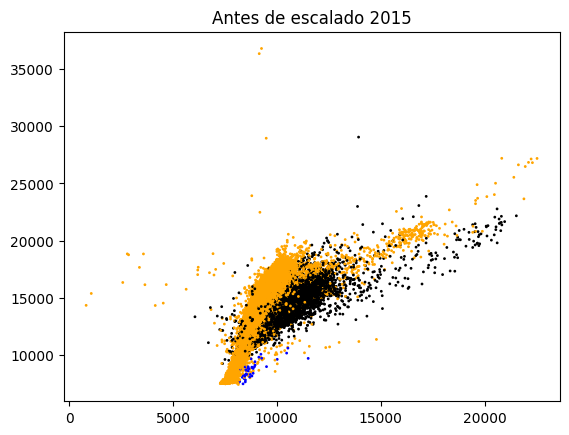

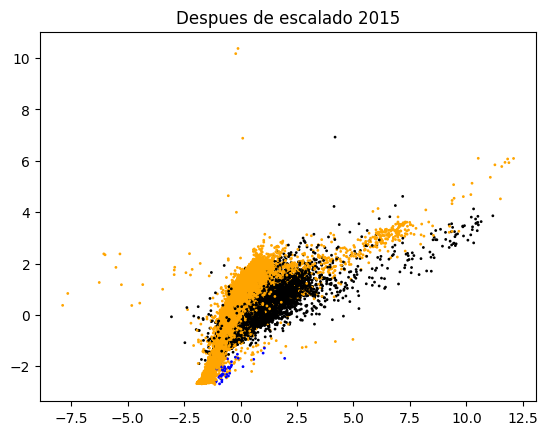

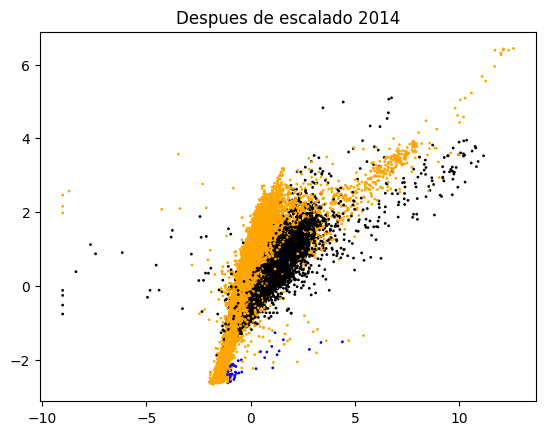

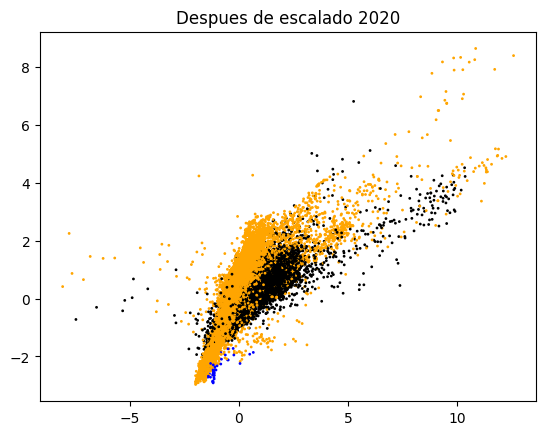

In [7]:
## visualización de la muestre de 50 k elementos
colors = ['orange', 'blue', 'black']
rango = slice(1000000,1050000)
colors_list = [colors[int(i) % 3] for i in y_labels_2015[rango,0]]

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Antes de escalado 2015')
plt.show()

scale = StandardScaler()
x_features_2014 = scale.fit_transform(x_features_2014)
x_features_2015 = scale.fit_transform(x_features_2015)
x_features_2020 = scale.fit_transform(x_features_2020)

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2015')
plt.show()

plt.scatter(x_features_2014[rango,0], x_features_2014[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2014')
plt.show()

plt.scatter(x_features_2020[rango,0], x_features_2020[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2020')
plt.show()

In [8]:
print(x_features_2015)
print(y_labels_2015)

[[-0.56036125 -0.83373913 -0.84875343 -1.29670839 -0.88645584 -0.75088024]
 [-0.57784197 -0.90195001 -0.87466271 -1.25955973 -0.76325186 -0.71837877]
 [-0.49319849 -0.8652775  -0.80557129 -1.12879644 -0.594474   -0.58659196]
 ...
 [-1.71960892 -1.96031882 -1.97033756 -3.28490482 -3.00255172 -2.62305428]
 [-1.68556752 -1.90164279 -1.89894309 -3.21853254 -2.90831419 -2.57452468]
 [-1.59356374 -1.83416536 -1.79069985 -3.11352566 -2.68662428 -2.40355802]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


Subdividir datos de entrenamiento y control (2015)

In [10]:
xTrain, xTest, yTrain, yTest = train_test_split(x_features_2015, y_labels_2015, test_size=0.2, random_state=242)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(3037104, 6)
(3037104, 1)
(759276, 6)
(759276, 1)
[[-0.55208091 -0.59023363 -0.39390155 -0.70133916  0.55568726  0.51222505]
 [ 0.43511969  0.78425226  0.67931859  0.83760611  0.16869546  0.24642531]
 [-0.25858884 -0.26384824 -0.2194457  -0.12082939  0.47496741  0.30564032]
 ...
 [-0.14266407 -0.1758342  -0.10602061 -0.5557164   0.62095833  0.45657183]
 [ 0.83993633  0.8707994   0.63268188  0.23183525  0.19186862  0.95522461]
 [-0.74252874 -0.94008943 -0.87639    -1.36951977 -0.97644495 -0.75488728]]
[[0]
 [2]
 [0]
 ...
 [0]
 [0]
 [0]]
(3037104, 1, 6) (759276, 1, 6)


Continuar entrenamiento de la red neuronal (ANN) simple pre-entrenada

In [13]:
from tensorflow import keras
from keras.models import load_model

## Cargar un modelo preentrenado
model = load_model('/content/drive/MyDrive/Colab Data/GDL_2015_model_ANN_2hl_3class.tensorflow')

print(model.summary())

# Continuar entrenamiento del modelo con datos adicionales
model.fit(xTrain, yTrain, epochs=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 20)                140       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 383 (1.50 KB)
Trainable params: 383 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/2
94910/94910 [==============================] - 216s 2ms/step - loss: 0.1522 - accuracy: 0.9428
Epoch 2/2
94910/94910 [=======================

In [14]:
model.save('/content/drive/MyDrive/Colab Data/GDL_2015_model_ANN_2hl_3class_posentrenado1.tensorflow')

In [15]:
# Predict for test data
yTestPredicted_raw = model.predict(xTest)
yTestPredicted_class = yTestPredicted_raw.argmax(axis=-1)

23728/23728 [==============================] - 40s 2ms/step


In [16]:
#yTestPredicted = yTestPredicted_raw[:,:]

## Aplicable solo para clasificacion binaria
#roc_auc_raw = roc_auc_score(yTest, yTestPredicted)
#yTestPredicted = (yTestPredicted>0.5).astype(int)
#yTestPredicted = yTestPredicted.argmax(axis=1)
#roc_auc = roc_auc_score(yTest, yTestPredicted)

## Aplicable para clasificacion multiclase
cMatrix = confusion_matrix(yTest, yTestPredicted_class)
accuracy = accuracy_score(yTest, yTestPredicted_class)
kappa = cohen_kappa_score(yTest, yTestPredicted_class)
pScore = precision_score(yTest, yTestPredicted_class, average=None)
rScore = recall_score(yTest, yTestPredicted_class, average=None)
f1Score = f1_score(yTest, yTestPredicted_class, average=None)

print("Confusion matrix:\n", cMatrix)
print("\nExactitud (accuracy): %.3f," % accuracy)
print("\nKappa de Cohen: %.3f," % kappa)
#print("\nROC AUC raw: %.3f," % roc_auc_raw)
#print("\nROC AUC: %.3f," % roc_auc)
print("\nClase 1. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[0], rScore[0], f1Score[0]))
print("\nClase 2. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[1], rScore[1], f1Score[1]))
print("\nClase 3. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[2], rScore[2], f1Score[2]))

Confusion matrix:
 [[599316    240  15366]
 [  1035   5470     85]
 [ 26140     15 111609]]

Exactitud (accuracy): 0.944,

Kappa de Cohen: 0.813,

Clase 1. Selectividad (precision): 0.957, especificidad (recall): 0.975, f1: 0.966

Clase 2. Selectividad (precision): 0.955, especificidad (recall): 0.830, f1: 0.888

Clase 3. Selectividad (precision): 0.878, especificidad (recall): 0.810, f1: 0.843


Predicción para datos de 2015

In [17]:
x_features_2015_n = x_features_2015
x_features_2015_n = x_features_2015_n.reshape((x_features_2015_n.shape[0], 1, x_features_2015_n.shape[1]))

predicted_2015 = model.predict(x_features_2015_n)
print(predicted_2015)

118637/118637 [==============================] - 208s 2ms/step
[[9.9743432e-01 1.8671757e-04 2.3790137e-03]
 [9.9932331e-01 5.4327596e-05 6.2228326e-04]
 [9.9933356e-01 3.8906794e-05 6.2742218e-04]
 ...
 [9.9427986e-01 5.5914884e-03 1.2855970e-04]
 [9.9402559e-01 5.8133923e-03 1.6101316e-04]
 [9.9840945e-01 1.4568043e-03 1.3379421e-04]]


Vista de la superficie de 2015 con etiquetas categoricas de mayor probabilidad

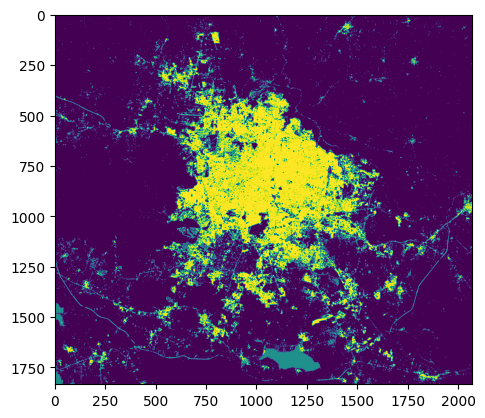

In [18]:
predicted_2015_class = predicted_2015.argmax(axis=-1)
predicted_2015_class_re = np.reshape(predicted_2015_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2015_class_re[:,:])
plt.show()

Superficie de probabilidad para clase urbano en 2015

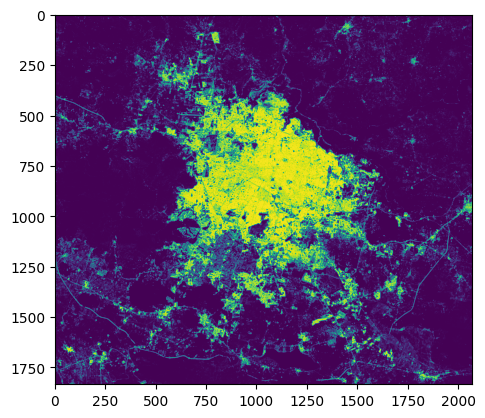

In [19]:
prediction_2015_urbano = np.reshape(predicted_2015[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2015 = (prediction_2015_urbano).astype('float')
plt.imshow(B_img_pred_2015[:,:])
plt.show()

Predicción para 2020

In [20]:
x_features_2020_n = x_features_2020
x_features_2020_n = x_features_2020_n.reshape((x_features_2020_n.shape[0], 1, x_features_2020_n.shape[1]))

predicted_2020 = model.predict(x_features_2020_n)
print(predicted_2020)

118637/118637 [==============================] - 215s 2ms/step
[[9.9934751e-01 9.2911294e-05 5.5960164e-04]
 [9.9956900e-01 6.1078885e-05 3.6989979e-04]
 [9.9936384e-01 9.4899537e-05 5.4125761e-04]
 ...
 [9.9939704e-01 3.1334153e-04 2.8957918e-04]
 [9.9958879e-01 1.9747061e-04 2.1383024e-04]
 [9.9974447e-01 1.5299889e-04 1.0246880e-04]]


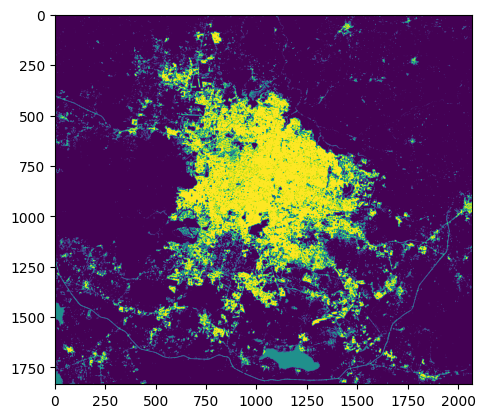

In [21]:
predicted_2020_class = predicted_2020.argmax(axis=-1)
predicted_2020_class_re = np.reshape(predicted_2020_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2020_class_re[:,:])
plt.show()

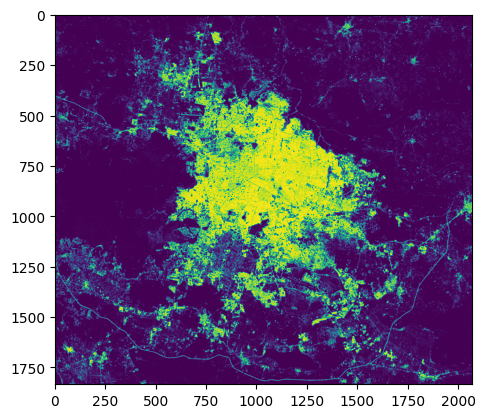

In [22]:
prediction_2020_urbano = np.reshape(predicted_2020[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2020 = (prediction_2020_urbano).astype('float')
plt.imshow(B_img_pred_2020[:,:])
plt.show()


Predicción para 2014

In [ ]:
x_features_2014_n = x_features_2014
x_features_2014_n = x_features_2014_n.reshape((x_features_2014_n.shape[0], 1, x_features_2014_n.shape[1]))

predicted_2014 = model.predict(x_features_2014_n)
print(predicted_2014)

118637/118637 [==============================] - 269s 2ms/step
[[9.9805456e-01 2.1694944e-04 1.7285207e-03]
 [9.9612480e-01 3.0008928e-04 3.5751341e-03]
 [9.9791646e-01 1.6327873e-04 1.9201884e-03]
 ...
 [9.9262249e-01 7.2457162e-03 1.3176924e-04]
 [9.9347901e-01 6.3359803e-03 1.8494971e-04]
 [9.9852055e-01 1.3935678e-03 8.5992018e-05]]


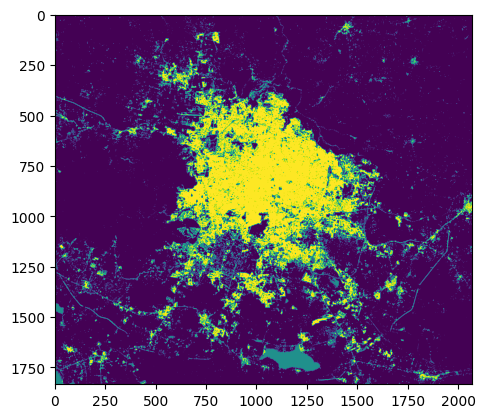

In [ ]:
predicted_2014_class = predicted_2014.argmax(axis=-1)
predicted_2014_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2014_class_re[:,:])
plt.show()

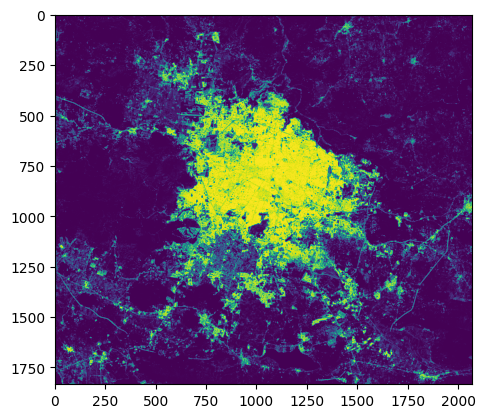

In [ ]:
prediction_2014_urbano = np.reshape(predicted_2014[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2014 = (prediction_2014_urbano).astype('float')
plt.imshow(B_img_pred_2014[:,:])
plt.show()

Guardar capas numpy de prediccion

In [ ]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/GDL_2014_prediction_class.npy', predicted_2014_class)
np.save('/content/drive/MyDrive/Colab Data/GDL_2015_prediction_class.npy', predicted_2015_class)
np.save('/content/drive/MyDrive/Colab Data/GDL_2020_prediction_class.npy', predicted_2020_class)
np.save('/content/drive/MyDrive/Colab Data/GDL_2014_prediction_urbano_float.npy', prediction_2014_urbano)
np.save('/content/drive/MyDrive/Colab Data/GDL_2015_prediction_urbano_float.npy', prediction_2015_urbano)
np.save('/content/drive/MyDrive/Colab Data/GDL_2020_prediction_urbano_float.npy', prediction_2020_urbano)